In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import glob
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score, denoise
from src.sampling_utils import random_step, langevin_step, repulsive_step_parallel
from src.kernel import RBF
from src.embedding import CNN64, CNN16, init_weights, AverageDim, Average, VAEAverage, Style

import torch
import torch.nn as nn
import torch.nn.functional as F
# import autograd.numpy as anp
from collections import deque

/data/ap2619/particlediffusion/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Using 512x512 resolution
model_id = "stabilityai/stable-diffusion-2-base"
# model_id = "CompVis/stable-diffusion-v1-4"

# tf32 faster computation with Ampere
torch.backends.cuda.matmul.allow_tf32 = True
device = "cuda"
dtype=torch.float32
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
# pipe = pipe.to(device)
pipe.safety_checker = None
pipe.enable_attention_slicing() # NOTE: 10% slower inference, but big memory savings
# pipe.enable_sequential_cpu_offload() # NOTE: May slow down inference a lot
pipe.enable_vae_slicing() # TODO: Try to give batches to VAE
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

# Traced UNet? https://huggingface.co/docs/diffusers/optimization/fp16

In [5]:
# Settings
prompt =  ["python developers hanging out"]
config = {
    "pipe": pipe,
    "height": 512,
    "width": 512,
    "num_inference_steps": 20,
    "num_train_timesteps": 1000,
    "num_init_latents": 1,
    "batch_size": 1,
    "cfg": 8,
    "beta_start": 0.00085,
    "beta_end": 0.012,
}

# Seeds
seed=1024
generator = torch.Generator(device).manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(0)
random.seed(0)

# Noise levels
sigmas, timesteps = get_sigmas(config, device=device)
init_latents, text_embeddings = get_score_input(prompt, config, generator=generator, device=device, dtype=dtype)
config = {**config,
          "sigmas": sigmas,
          "timesteps": timesteps,
          "init_latents": init_latents,
          "text_embeddings": text_embeddings
          }

In [6]:
latent = denoise([1], 0, config, return_all_samples=False, generator=generator)

100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


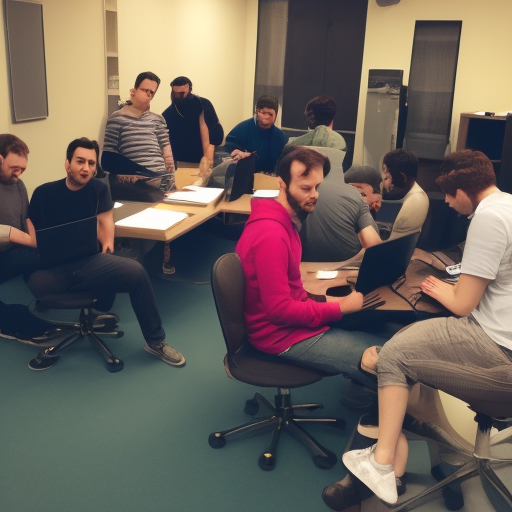

In [7]:
# Plot image results
image = output_to_img(decode_latent(latent, config['pipe'].vae))
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [10]:
# Exporting model to onnx
x = torch.randn_like(latent)
torch.onnx.export(pipe.unet, x.cpu(), 'unet.onnx', input_names=["latent"], output_names=["score"], operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Particles

In [7]:
path = "model16.pt"
net = CNN16()
# path = "model.pt"
# net = CNN64()
save_weights = False

if save_weights:
    # Initialise weights
    net.apply(init_weights)
    # Store weights and model
    torch.save(net.state_dict(), path)

# Load model instead of re-initialising
net.load_state_dict(torch.load(path))
net.to(torch.device("cuda"))

CNN16(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
  (act): ReLU()
)

In [9]:
Style(AverageDim())(latent)

tensor([ 0.4775, -0.1659, -0.2544, -0.1611,  0.0577,  0.0884,  0.0560,  0.1356,
         0.0858,  0.0543], device='cuda:0')

In [9]:
def repulsive_step_parallel(
        particles,
        scores,
        phi_history,
        model,
        K,
        generator,
        repulse=True,
        add_noise = True,
        step_size=0.2,
        snr=1, # strength of repulsive term
        phi_history_size=100,
        device="cuda",
    ):
        """ Take repulsive langevin step. 
            particles: list of latent samples
            scores: list of scores for each latent sample
            phi_history: List of previous phi particles used
            model: embedding model for latents to smaller dim space
            K: Kernel function
            generator: generator
            repulse: whether to repulse with repulsion term, or condition (repulse=False) by going in the opposite direction
        
        """
        # Checks
        n = len(particles)
        if n<=1:
             print("WARNING: Cannot repulse 1 particle on its own, add more particles")
             return
        if n > phi_history_size:
            phi_history_size=n
        
        # Embed latent to smaller dimension
        with torch.no_grad():
            phi = model(particles)

        # Add to phi_history FIFO
        if phi_history:
            history_space = phi_history_size - phi_history.shape[0]
            if n > history_space:
                phi_history = torch.cat((phi_history[n:], phi))
            else:
                phi_history = torch.cat((phi_history, phi))
        else:
            phi_history = phi

        # Compute gradient ∇_latent (phi) for pushforward gradient computation (shape= (NxE) x (Nx4x64x64)) E is output size of model
        # TODO: Should grad be found with all particles or each particle separate... I only need the grad of a phi with its own particle, not every other one
        grads = torch.autograd.functional.jacobian(
            model, 
            particles.clone().detach().requires_grad_()
        )
        
        # Set bandwidth of RBF kernel with median heuristic
        K.bandwidth(phi_history, phi_history)
        print(f"Sigma: {K.sigma.item()}")
        # Kernel grad shape: embedding_size x num_particles x num_particles
        kernel_grad = K.grad_first(phi_history, phi_history)
        kernel_grad_sum = torch.sum(kernel_grad, axis=-1)

        # Repulsive term TODO: vectorize this for loop
        new_particles = []
        for i in range(n):
            # Pushforward/Chain rule
            # TODO: Check this multiplication is right
            repulsive = torch.einsum('i,ijklm->jklm',kernel_grad_sum[:,i-n], grads[i,:,i,...].unsqueeze(1)) / n

            # (debug) Get repulsion norm
            # repulsive_norm = torch.norm(repulsive.reshape(repulsive.shape[0], -1), dim=-1).mean()
            # score_norm = torch.norm(scores[i].reshape(scores[i].shape[0], -1), dim=-1).mean()
            # repulsive_scale = snr * score_norm / repulsive_norm
            # print(repulsive_norm.item())

            # (debug) Save repulsion term
            # torch.save(repulsive, f'repulsive{i}.pt')

            # Score + Repulsion
            if repulse:
                new_particle = particles[i] + step_size * (scores[i] - 100*repulsive)
            else:
                new_particle = particles[i] + step_size * (scores[i] + 100*repulsive)
            # ONLY Repulsion
            # new_particle = particles[i] - step_size * (repulsive_scale * repulsive)
            if add_noise:
                noise = torch.randn(particles[i].shape, layout=particles[i].layout, device=device, generator=generator).to(device)
                new_particle += ((step_size * 2) ** 0.5) * noise

            new_particles.append(new_particle)
        return torch.cat(new_particles,axis=0)

In [11]:
# WIP: Repulsion in series
def get_phi_grad(particle, model):
    # Get (phi, ∇_latent (phi))
    # Embed latent to smaller dimension
    phi = model(particle)
    # Compute gradient ∇_latent (phi) for pushforward gradient computation
    grad = torch.autograd.functional.jacobian(
        model, 
        particle.clone().detach().requires_grad_()
    )
    return (phi, grad)


def repulsive_step(
        particle,
        score,
        phi_history,
        model,
        K,
        generator,
        add_noise = False,
        step_size=0.2,
        snr=100, # strength of repulsive term
        device="cuda",
    ):
        """ Take repulsive langevin step. 
            particles: list of latent samples
            scores: list of scores for each latent sample
            phi_history: List of previous phi particles and their gradients
            model: embedding model for latents to smaller dim space
            K: Kernel function
        
        """
        # Compute kernel gradients
        tphis = torch.stack([phi_grad[0] for phi_grad in phi_history],axis=0)
        # Set bandwidth of RBF kernel with median heuristic
        K.bandwidth(tphis, tphis)
        print(f"Sigma: {K.sigma.item()}")
        # Kernel grad shape: embedding_size x num_particles x num_particles
        kernel_grad = K.grad_first(tphis, tphis)
        kernel_grad_sum = torch.sum(kernel_grad, axis=-1)

        # Repulsive term
        # Pushforward/Chain rule for last particle added
        repulsive = torch.einsum('i,ijklm->jklm',kernel_grad_sum[:,-1], grad)

        # (debug) Get repulsion norm
        repulsive_norm = torch.norm(repulsive.reshape(repulsive.shape[0], -1), dim=-1).mean()
        score_norm = torch.norm(repulsive.reshape(score.shape[0], -1), dim=-1).mean()
        repulsive_scale = snr * score_norm / repulsive_norm
        print(repulsive_norm.item())

        # (debug) Save repulsion term
        # torch.save(repulsive, f'repulsive{i}.pt')

        # Score + Repulsion
        # new_particle = particles[i] + step_size * (scores[i] + repulsive_scale * repulsive)
        # ONLY Repulsion
        new_particle = particle + step_size * (repulsive_scale * repulsive)
        if add_noise:
            noise = torch.randn(particle.shape, layout=particle.layout, device=device, generator=generator).to(device)
            new_particle += ((step_size * 2) ** 0.5) * noise

        return new_particle

In [12]:
# Testing: Comparing distance between particle latents
def compare_particles(init_particles, particles, model):
    # L2 distance between initial and evolved particles in SD2 latent space and model embedding latent space
    n = len(init_particles)
    sd_diff = 0
    emb_diff = 0
    for i in range(n):
        sd_diff += torch.mean((init_particles[i]-particles[i])**2)
        emb_diff += torch.mean((model(init_particles[i]) - model(particles[i]))**2)
    
    sd_diff/=n
    emb_diff/=n
    print(f"SD2 L2 distance: {sd_diff}")
    print(f"Embedding L2 distance: {emb_diff}")

def spread(particles):
    # Get L2 distances between particles
    spread=0
    n = len(particles)
    for i in range(n):
        for j in range(i+1,n):
            spread += torch.mean((particles[i]-particles[j])**2)
    
    return spread

In [13]:
def correct_particles(
    particles,
    sigma,
    t,
    correction_steps,
    correction_method,
    config,
    generator,
    step_size=0.2,
    model=None,
    kernel=None,
    
    ):
    """ At certain noise scale (step t), apply correction steps to all particles
        particles: N particles in the diffusion process
        method (str): type of correction step "random", "langevin", "score", or "repulsive"
        model: Embedding model (must be defined if repulsive correct_type specified)
        K: RBF Kernel (must be defined if repulsive correct_type specified)
        TODO: Make sampler factory class
    """
    if correction_method=="random":
        particles = random_step(particles, correction_steps, generator, step_size=step_size)
    elif correction_method=="repulsive":
        # Parallel particles
        phi_history = None
        for i in range(correction_steps):
            scores = get_score(particles, sigma, t, config)
            particles = repulsive_step_parallel(particles, scores, phi_history, model, kernel, generator, step_size=step_size)
            with torch.no_grad():
                print(f"Correction {i} spread: SD - {spread(particles)} embedding - {spread(model(particles))}")

    # elif correction_method=="repulsive_series":
        # TODO: Update particles one at a time
        # phi_history = deque([], phi_history_size)
        # # Add particles 
        # for particle in particles:
        #     phi_grad = get_phi_grad(particle, model)
        #     phi_history.append(phi_grad)

        # for i in range(correction_steps):
        #     for n in range(len(particles)):
        #         score = get_score(particles[n], sigma, t, config)
        #         particles[n] = repulsive_step(particles[n], scores, phi_grad, phi_history, model, kernel, generator, step_size=step_size)
        #         print(f"Correction {i} spread: SD - {spread(particles)} embedding - {spread([model(particle) for particle in particles])}")
        # new_particles = particles

    elif correction_method=="langevin" or correction_method=="score":
        add_noise = (correction_method=="langevin")
        for _ in range(correction_steps):
            score = get_score(particles, sigma, t, config)
            particles = langevin_step(particles, score, generator, step_size=step_size, add_noise=add_noise)
    else:
        print(f"ERROR: Correction step type: '{correction_method}' not implemented yet")
            
    return particles

def denoise_particles(
    config,
    generator,
    correction_levels=[],
    correction_steps=[],
    correction_step_size="auto",
    correction_method=["langevin"],
    addpart_level=0,
    addpart_steps=1,
    addpart_step_size=0.2,
    addpart_method="langevin",
    num_particles=1,
    model=None,
    kernel=RBF(),
    device="cuda",
):
    """ General function to take steps and add particles at different noise levels of diffusion
        correction_levels (List[int]): noise level indices to do correction steps in
        correction_steps (List[int]): number of correction steps to take in each noise level
        correction_method (List[str]): method of correction e.g. random, langevin, score, repulsive
        addpart_level (int): noise level index to add particles in
        addpart_steps (int): number of steps taken between particles
        addpart_method (str): method of steps for adding particles e.g. random, langevin, score (NOT repulsive)
        config (Dict): info for diffusion
        generator: RNG generator - reset before calling this method
        num_particles=2: number of particles to add at addpart_level
        Model: Embedding model for repulsion
        model_path: path to embedding model weights
        Kernel=RBF: Kernel class to use for repulsive steps
        device="cuda",
    """
    if addpart_method=="repulsive":
        print("Cannot use repulsive steps to add new particles.")
        return None
    # standard deviation of the initial noise distribution
    sigmas = config['sigmas']

    # Denoise particles
    particles = config['init_latents'] * sigmas.max() # 1x4x64x64
    for i, t in enumerate(tqdm(config['timesteps'])):
        t = t.to(device)
        step_index = (config['timesteps'] == t).nonzero().item()
        sigma = sigmas[step_index]

        # Create particles
        if i==addpart_level:
            # TODO: Optimise having to re-calculate gradient for duplicate particles each time
            particles = torch.concat([particles] + [particles[0].unsqueeze(0)] * (num_particles-1))
            particles = correct_particles(
                particles, 
                sigma, 
                t, 
                correction_steps=addpart_steps, 
                correction_method=addpart_method,
                config=config, 
                generator=generator, 
                step_size=addpart_step_size, 
                model=model, 
                kernel=kernel
            )
        
        # Correction steps
        for idx, correction_level in enumerate(correction_levels):
            if i==correction_level:
                print(idx)
                # Automatic step_size using sigmas
                if correction_step_size=="auto":
                    correction_step_size = sigma * (sigma - sigmas[step_index + 1]) / correction_steps[idx]
                    print(correction_step_size.item())

                particles = correct_particles(
                    particles, 
                    sigma, 
                    t, 
                    correction_steps[idx], 
                    correction_method=correction_method[idx], 
                    config=config, 
                    generator=generator, 
                    step_size=correction_step_size, 
                    model=model, 
                    kernel=kernel
                )
            
        # Move to next marginal in diffusion
        scores = get_score(particles, sigma, t, config)
        particles = step_score(particles, scores, sigmas, step_index)
    
    return particles

In [11]:
sigmas

tensor([14.6146, 10.7468,  8.0815,  6.2050,  4.8557,  3.8654,  3.1238,  2.5572,
         2.1157,  1.7648,  1.4806,  1.2458,  1.0481,  0.8784,  0.7297,  0.5964,
         0.4736,  0.3555,  0.2322,  0.0292,  0.0000], device='cuda:0')

In [8]:
pipe.unet.conv_in(latent).shape

torch.Size([1, 320, 64, 64])

In [12]:
scores = get_score(latent, sigmas[0], timesteps[0], config)

In [14]:
latent.shape

torch.Size([1, 4, 64, 64])

In [25]:
noise_pred = pipe.unet(latent, timesteps[0], encoder_hidden_states=text_embeddings[0].unsqueeze(0)).sample

In [26]:
pipe.unet.conv_norm_out

GroupNorm(32, 320, eps=1e-05, affine=True)

In [20]:
latent = latent.requires_grad_()
x = pipe.vae.decode(latent).sample.mean(axis=(2,3))

x.backward()
latent.grad.shape

RuntimeError: grad can be implicitly created only for scalar outputs

In [12]:
grads = torch.autograd.functional.jacobian(
            net, 
            latent
        )

In [13]:
grads.shape

torch.Size([1, 16, 1, 4, 64, 64])

In [11]:
x.shape

torch.Size([1, 16])

In [10]:
x = net(latent)
x.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

In [28]:
from torch.func import jacfwd, jacrev
grad1 = jacrev(net)(latent)
grad2 = jacfwd(net)(latent.clone().requires_grad_())

In [29]:
grad1

tensor([[[[[[ 2.9314e-06,  2.5469e-05, -1.2289e-06,  ...,  3.4249e-05,
             -3.4231e-06, -1.7966e-05],
            [ 2.2930e-05, -1.4108e-05, -4.6561e-05,  ..., -4.6732e-05,
              6.6101e-05,  1.4712e-05],
            [ 2.9138e-06,  2.4602e-05,  7.1290e-05,  ...,  4.4436e-05,
              8.8963e-06, -1.4970e-05],
            ...,
            [-2.0362e-05, -1.0856e-05,  1.9135e-05,  ..., -6.4898e-06,
              2.2549e-05,  3.6628e-06],
            [-1.0634e-06, -2.3980e-06,  3.3579e-06,  ...,  8.7634e-06,
              2.7609e-06, -2.6116e-06],
            [-9.7424e-06, -7.7661e-06,  4.6824e-06,  ..., -4.4682e-06,
              6.5922e-06,  5.8596e-06]],

           [[ 1.1449e-06, -3.8580e-06, -4.1118e-06,  ..., -1.0233e-05,
              5.9132e-06,  4.1123e-06],
            [-3.4088e-05,  1.9111e-05,  8.6260e-05,  ..., -2.6401e-05,
             -2.3153e-05, -1.3057e-05],
            [ 2.3834e-06, -4.8706e-05,  3.7359e-05,  ..., -1.7116e-05,
             -2.0968e-

In [ ]:
grad1

In [36]:
torch.allclose(grad1, grad2, equal_nan=True)

False

In [13]:
grads.shape

torch.Size([1, 16, 1, 4, 64, 64])

In [26]:
s = pipe.vae.post_quant_conv(latent)

In [25]:
pipe.vae.post_quant_conv.to("cuda")

Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))

In [20]:
s.min()

tensor(-1.4608, grad_fn=<MinBackward1>)

In [46]:
torch.amax(lat, dim=(2,3))

tensor([[1.3465, 0.5918, 0.5252, 0.4532]], device='cuda:0',
       grad_fn=<AmaxBackward0>)

In [28]:
vert = torch.mean(latent[...,32:, :] - latent[...,:32,:], axis=(2,3))
horz = torch.mean(latent[...,:, :32] - latent[...,:,32:], axis=(2,3))

In [29]:
vert.shape

torch.Size([1, 4])

In [31]:
torch.cat((vert, horz), axis=1)

tensor([[-0.1727, -0.5321,  0.3154,  0.3559,  0.2666,  0.4641,  0.0012, -0.2403]],
       device='cuda:0')

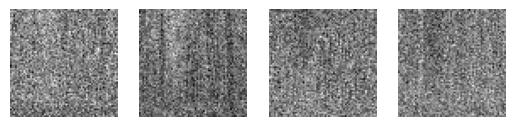

In [16]:
lat = latent[6].permute(2,3,1,0).squeeze().cpu().detach()[...,:]
lat -= torch.amin(lat, dim=(0,1))
lat /= torch.amax(lat, dim=(0,1))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.imshow(lat[...,i], cmap='gray')
filename = f"data/latent.png"
plt.savefig(filename)

In [14]:
latent.shape

torch.Size([1, 4, 64, 64])

In [15]:
diff1 = latent[...,32:,32:] - latent[...,:32,:32]

In [16]:
diff1.shape

torch.Size([1, 4, 32, 32])

In [39]:
pipe.unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Linear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_f

In [14]:
seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
# Embedding model for repulsive force
# model = CNN16(relu=False)
# model_path = "model16.pt"
# model.load_state_dict(torch.load(model_path))
# model.to(torch.device("cuda"))
# model=VAEAverage(vae=pipe.vae)
model=AverageDim()
# model=SoftBoundedAverage()
# Denoise
numparticles=3
particles = denoise_particles(config, generator, num_particles=numparticles, 
                                correction_levels=[], 
                                correction_steps=[1], 
                                correction_method=["repulsive"], 
                                correction_step_size="auto",
                                model=model)

100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


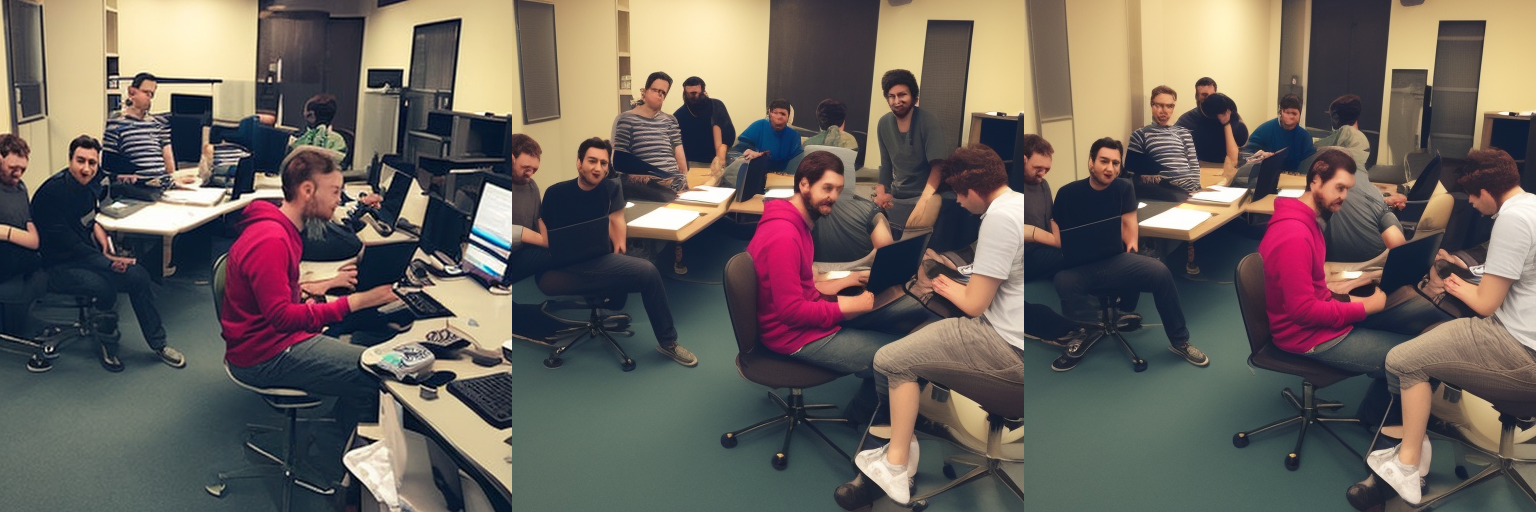

In [15]:
# Plot image results
images = output_to_img(decode_latent(particles, pipe.vae))
images = (images * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

max_cols = 10
ncols = max_cols if numparticles > max_cols else numparticles
nrows = int(np.ceil(numparticles / ncols))
grid = image_grid(pil_images,nrows,ncols)
grid

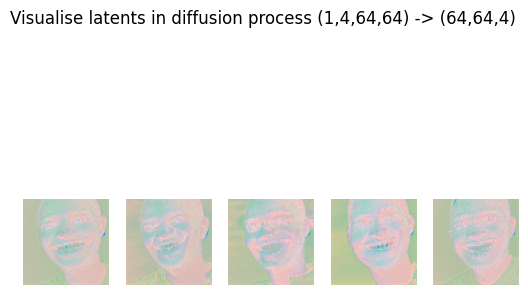

In [26]:
visualise_latent_list = particles

import matplotlib.pyplot as plt
lats = [pipe.vae.post_quant_conv(l) for l in visualise_latent_list]
lats = latent_to_img(lats)
# plt.figure(figsize=(10,5))
plt.suptitle("Visualise latents in diffusion process (1,4,64,64) -> (64,64,4)")
for i, lat in enumerate(lats):
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(lat)

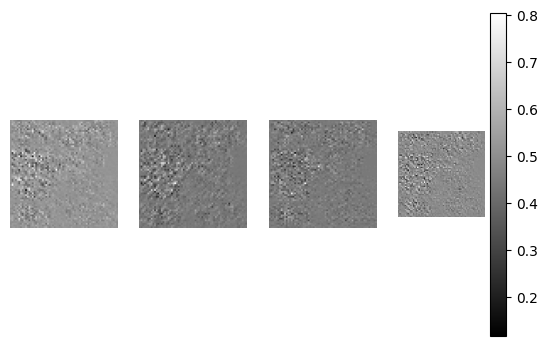

In [51]:
# Plot repulsive term
repulsive = torch.load('repulsive3.pt')
lat = latent_to_img([repulsive])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    plt.imshow(lat[0][...,i], cmap='gray')
plt.colorbar()

In [33]:
repulsive

tensor([[[[ 9.2832e-04,  4.5789e-03,  2.6533e-04,  ..., -2.9138e-03,
            3.6366e-04,  1.9170e-03],
          [-1.8788e-04,  2.7751e-03, -2.7535e-03,  ...,  3.3567e-03,
           -6.2588e-03,  6.5956e-03],
          [ 4.3384e-04, -7.9534e-04,  3.2360e-03,  ..., -1.6692e-03,
            1.2745e-04,  6.0662e-03],
          ...,
          [ 3.4474e-05, -5.3542e-03,  5.6124e-04,  ..., -9.0950e-03,
           -1.5915e-03, -5.8526e-05],
          [-7.8929e-04, -4.0249e-03,  1.1507e-03,  ..., -1.2887e-04,
           -2.8203e-03, -2.2863e-03],
          [ 5.5013e-03, -1.7029e-03, -3.7889e-03,  ..., -3.0377e-03,
            1.7352e-03, -3.0281e-03]],

         [[ 1.0522e-03,  1.7171e-05, -1.4525e-03,  ..., -2.2544e-04,
            1.8536e-03,  1.7626e-03],
          [-1.3582e-03, -5.1985e-03,  1.9834e-03,  ..., -5.1391e-03,
            8.6768e-03,  2.2434e-03],
          [-9.7662e-04, -4.5187e-03,  9.0732e-04,  ...,  1.6637e-04,
            4.8782e-03,  1.4940e-03],
          ...,
     

In [20]:
lat[0].shape

torch.Size([64, 64, 4])

In [15]:
grid.save("experiments/test.png")

In [ ]:
# Plot repulsive norms
with open('out.txt') as f:
    lines = f.readlines()
norms = [float(line.split()[0]) for line in lines]
plt.plot(norms[::2], label="particle 1")
plt.plot(norms[1::2], label="particle 2")
plt.legend()
plt.ylabel("Repulsive term magnitude")
plt.xlabel("Steps")

In [14]:
import os, glob
for file in glob.glob("data/denoise_results/*/*/*"):
    new_file_name = file[:-25]+"0_stepseed"+file[-25:-6]+"_"+file[-5:]
    os.rename(file, new_file_name)

In [13]:
a = "data/denoise_results/langevin/a_black_cat/lvl12_seed4_nsteps100_stepsz0.1.png"
a[:-25]+"0_stepseed"+a[-25:-6]+"_"+a[-5:]

'data/denoise_results/langevin/a_black_cat/lvl12_seed0_stepseed4_nsteps100_stepsz0_1.png'

In [18]:
torch.mean((particles[1]-particles[2])**2) #0.2674

tensor(0.4009, device='cuda:0', grad_fn=<MeanBackward0>)

Saving images

In [ ]:
import os, glob
import imageio.v3 as iio
for seed in range(2):
    for lvl in [1]:
        rows = []
        for file in glob.glob(f"data/denoise_results/langevin/a_black_cat_seed{seed}/lvl{lvl}_*"):
            rows.append(iio.imread(file))
        plt.figure(figsize=(20,20))
        plt.axis('off')
        plt.imshow(np.concatenate(rows, axis=0))
        name = f'langevin_lvl{seed}_seed{lvl}_nsteps100_stepsz0_1'
        plt.title(name)
        plt.savefig(f'data/denoise_results/langevin/collage/{name}.png')

In [15]:
os.path.basename(file)

'lvl0_seed0_stepseed13_nsteps100_stepsz0_1.png'

In [ ]:
# plot score
for seed in range(2):
    rows = []
    for file in glob.glob(f"data/denoise_results/score/a_black_cat_seed{seed}/*"):
        rows.append(iio.imread(file))
    plt.figure(figsize=(20,20))
    plt.axis('off')
    plt.imshow(np.concatenate(rows, axis=0))
    name = f'score_seed{seed}_nsteps100_stepsz0_1'
    plt.title(name)
    plt.savefig(f'data/denoise_results/score/collage/{name}.png')